In [1]:
zip_path = '/content/sample_data/cnn_dataset.zip'
unzip_dir = '/content'

import zipfile
import os

if not os.path.exists(unzip_dir):
    os.makedirs(unzip_dir)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("Dataset extracted successfully.")
data_path = unzip_dir

Dataset extracted successfully.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
!pip install torchinfo
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
data_path = '/content/cnn_dataset'
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Split dataset into train, validation, and test sets (80%, 10%, 10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 80640
Validation set size: 10080
Test set size: 10080


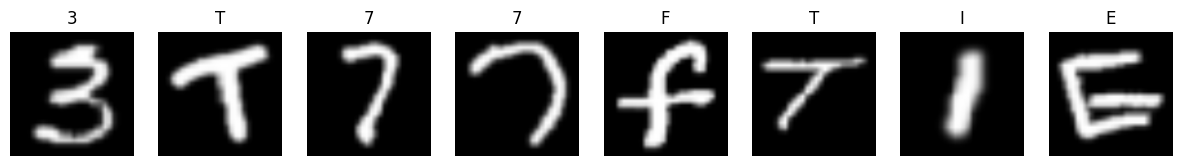

Number of images: 100800
Number of classes: 36
Class distribution:
0: 2800 images
1: 2800 images
2: 2800 images
3: 2800 images
4: 2800 images
5: 2800 images
6: 2800 images
7: 2800 images
8: 2800 images
9: 2800 images
A: 2800 images
B: 2800 images
C: 2800 images
D: 2800 images
E: 2800 images
F: 2800 images
G: 2800 images
H: 2800 images
I: 2800 images
J: 2800 images
K: 2800 images
L: 2800 images
M: 2800 images
N: 2800 images
O: 2800 images
P: 2800 images
Q: 2800 images
R: 2800 images
S: 2800 images
T: 2800 images
U: 2800 images
V: 2800 images
W: 2800 images
X: 2800 images
Y: 2800 images
Z: 2800 images


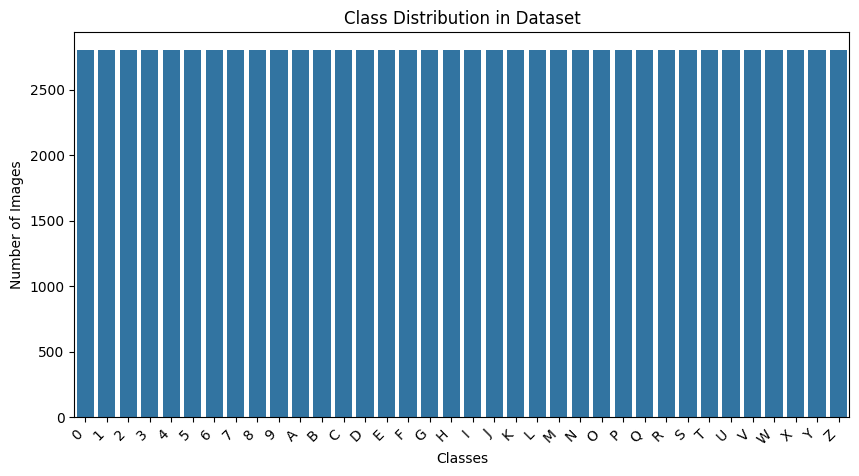

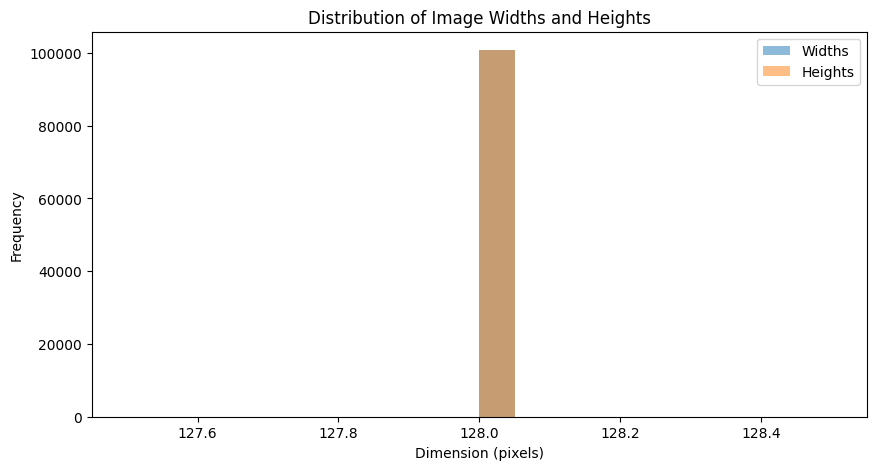

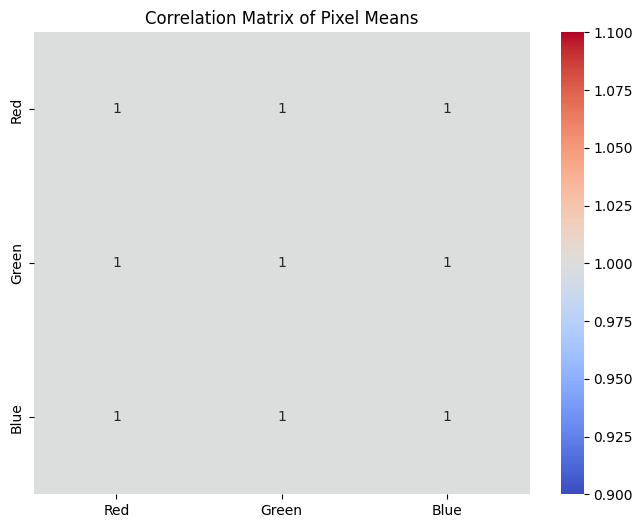

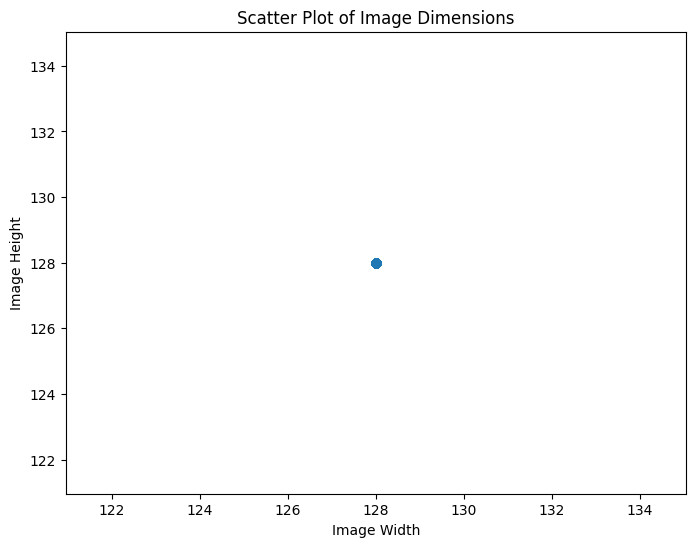

In [13]:
def print_images(dataloader, classes, num_images=8):
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].set_title(classes[labels[i].item()])
        axes[i].axis('off')
    plt.show()

print_images(train_dataloader, dataset.classes)

def analyze_dataset(dataset):
    print(f"Number of images: {len(dataset)}")
    print(f"Number of classes: {len(dataset.classes)}")
    print("Class distribution:")
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1
    for i, count in enumerate(class_counts):
        print(f"{dataset.classes[i]}: {count} images")

    # bar plot of class distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=dataset.classes, y=class_counts)
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    image_widths = []
    image_heights = []
    for img, _ in dataset:
      image_widths.append(img.shape[1])
      image_heights.append(img.shape[2])

    plt.figure(figsize=(10, 5))
    plt.hist(image_widths, bins=20, alpha=0.5, label='Widths')
    plt.hist(image_heights, bins=20, alpha=0.5, label='Heights')
    plt.xlabel("Dimension (pixels)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Image Widths and Heights")
    plt.legend(loc='upper right')
    plt.show()

    # Correlation Matrix
    pixel_means = []
    for img, _ in dataset:
        pixel_means.append(torch.mean(img, dim=[1, 2]).numpy())

    pixel_means = np.array(pixel_means)
    if pixel_means.shape[1] >= 2:
        correlation_matrix = np.corrcoef(pixel_means, rowvar=False)
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
                    xticklabels=['Red', 'Green', 'Blue'],
                    yticklabels=['Red', 'Green', 'Blue'])
        plt.title("Correlation Matrix of Pixel Means")
        plt.show()
    else:
        print("Not enough channels for a correlation matrix")

    # Scatter Plot
    image_widths = []
    image_heights = []
    for img, _ in dataset:
      image_widths.append(img.shape[1])
      image_heights.append(img.shape[2])

    plt.figure(figsize=(8, 6))
    plt.scatter(image_widths, image_heights, alpha=0.5)
    plt.xlabel("Image Width")
    plt.ylabel("Image Height")
    plt.title("Scatter Plot of Image Dimensions")
    plt.show()

analyze_dataset(dataset)


In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv4(x)))  # Conv4 -> ReLU -> MaxPool
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))  # FC1 -> ReLU -> Dropout
        x = self.fc2(x)  # FC2 (output layer)
        return x

num_classes = len(dataset.classes)
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 36]                  --
├─Conv2d: 1-1                            [32, 32, 128, 128]        896
├─MaxPool2d: 1-2                         [32, 32, 64, 64]          --
├─Conv2d: 1-3                            [32, 64, 64, 64]          18,496
├─MaxPool2d: 1-4                         [32, 64, 32, 32]          --
├─Conv2d: 1-5                            [32, 128, 32, 32]         73,856
├─MaxPool2d: 1-6                         [32, 128, 16, 16]         --
├─Conv2d: 1-7                            [32, 256, 16, 16]         295,168
├─MaxPool2d: 1-8                         [32, 256, 8, 8]           --
├─Linear: 1-9                            [32, 512]                 8,389,120
├─Dropout: 1-10                          [32, 512]                 --
├─Linear: 1-11                           [32, 36]                  18,468
Total params: 8,796,004
Trainable params: 8,796,004
Non-trai

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss_history.append(running_train_loss / len(train_dataloader))
        train_accuracy_history.append(100 * correct_train / total_train)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss_history.append(running_val_loss / len(val_dataloader))
        val_accuracy_history.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {running_train_loss/len(train_dataloader):.4f}, Train Accuracy: {100*correct_train/total_train:.2f}%")
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {running_val_loss/len(val_dataloader):.4f}, Val Accuracy: {100*correct_val/total_val:.2f}%")

    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

def evaluate_test_set(model, test_dataloader, criterion):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss = running_test_loss / len(test_dataloader)
    test_accuracy = 100 * correct_test / total_test
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return test_loss, test_accuracy, precision, recall, f1

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train the model
train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, epochs=5)


Epoch 1/5 - Train Loss: 0.6304, Train Accuracy: 79.69%
Epoch 1/5 - Val Loss: 0.3063, Val Accuracy: 88.66%
Epoch 2/5 - Train Loss: 0.3374, Train Accuracy: 88.07%
Epoch 2/5 - Val Loss: 0.2748, Val Accuracy: 89.98%
Epoch 3/5 - Train Loss: 0.2897, Train Accuracy: 89.45%
Epoch 3/5 - Val Loss: 0.2510, Val Accuracy: 90.59%
Epoch 4/5 - Train Loss: 0.2581, Train Accuracy: 90.48%
Epoch 4/5 - Val Loss: 0.2551, Val Accuracy: 90.35%
Epoch 5/5 - Train Loss: 0.2347, Train Accuracy: 91.00%
Epoch 5/5 - Val Loss: 0.2407, Val Accuracy: 90.63%
Training Time: 674.73 seconds


In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy, precision, recall, f1 = evaluate_test_set(model, test_dataloader, criterion)
test_accuracy_history = [test_accuracy] * len(train_accuracy_history)
test_loss_history = [test_loss] * len(train_loss_history)

Test Loss: 0.2362, Test Accuracy: 91.22%
Precision: 0.9156, Recall: 0.9122, F1 Score: 0.9103


Batch Normalization:
-------------------------

In [18]:
class BatchNormalizationCNN(nn.Module):
    def __init__(self, num_classes):
        super(BatchNormalizationCNN, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization after Conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after Conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # Batch Normalization after Conv3
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256) # Batch Normalization after Conv4
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BN -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Conv4 -> BN -> ReLU -> MaxPool
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))  # FC1 -> ReLU -> Dropout
        x = self.fc2(x)  # FC2 (output layer)
        return x


In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(dataset.classes)
batch_model = BatchNormalizationCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_model.to(device)

# Train the model
batch_train_loss_history, batch_val_loss_history, batch_train_accuracy_history, batch_val_accuracy_history = train_model(
    batch_model, train_dataloader, val_dataloader, criterion, optimizer, epochs=5)
# Evaluate the model on the test set
batch_test_loss, batch_test_accuracy, batch_precision, batch_recall, batch_f1 = evaluate_test_set(batch_model, test_dataloader, criterion)
batch_test_accuracy_history = [batch_test_accuracy] * len(batch_train_accuracy_history)
batch_test_loss_history = [batch_test_loss] * len(batch_train_loss_history)

Epoch 1/5 - Train Loss: 0.1206, Train Accuracy: 94.88%
Epoch 1/5 - Val Loss: 0.2596, Val Accuracy: 91.70%
Epoch 2/5 - Train Loss: 0.1120, Train Accuracy: 95.25%
Epoch 2/5 - Val Loss: 0.2631, Val Accuracy: 91.69%
Epoch 3/5 - Train Loss: 0.1065, Train Accuracy: 95.51%
Epoch 3/5 - Val Loss: 0.2784, Val Accuracy: 91.76%
Epoch 4/5 - Train Loss: 0.1027, Train Accuracy: 95.64%
Epoch 4/5 - Val Loss: 0.2852, Val Accuracy: 91.83%
Epoch 5/5 - Train Loss: 0.0999, Train Accuracy: 95.69%
Epoch 5/5 - Val Loss: 0.2950, Val Accuracy: 91.87%
Training Time: 738.94 seconds
Test Loss: 0.3245, Test Accuracy: 89.21%
Precision: 0.8923, Recall: 0.8907, F1 Score: 0.8915


Learning Rate scheduler:
------------------------

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

lr_model = CNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

def train_model_with_scheduler(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs):
    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train, total_train = 0, 0

        # Training loop
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_dataloader)
        train_accuracy = 100 * correct_train / total_train
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_dataloader)
        val_accuracy = 100 * correct_val / total_val
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        scheduler.step(val_loss)
        print(f"Learning rate after epoch {epoch+1}: {scheduler.get_last_lr()[0]:.6f}")

    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

lr_train_loss_history, lr_val_loss_history, lr_train_accuracy_history, lr_val_accuracy_history = train_model_with_scheduler(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs=5)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Train Loss: 0.1339, Train Acc: 94.37%
Val Loss: 0.2709, Val Acc: 91.40%
Learning rate after epoch 1: 0.001000
Epoch 2/5, Train Loss: 0.1304, Train Acc: 94.57%
Val Loss: 0.2664, Val Acc: 91.32%
Learning rate after epoch 2: 0.001000
Epoch 3/5, Train Loss: 0.1266, Train Acc: 94.59%
Val Loss: 0.2801, Val Acc: 91.08%
Learning rate after epoch 3: 0.001000
Epoch 4/5, Train Loss: 0.1241, Train Acc: 94.71%
Val Loss: 0.2905, Val Acc: 91.22%
Learning rate after epoch 4: 0.001000
Epoch 5/5, Train Loss: 0.1187, Train Acc: 95.04%
Val Loss: 0.2857, Val Acc: 91.05%
Learning rate after epoch 5: 0.001000
Training Time: 633.18 seconds


In [30]:
# Evaluate the model on the test set
lr_test_loss, lr_test_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_test_set(lr_model, test_dataloader, criterion)
lr_test_accuracy_history = [lr_test_accuracy] * len(lr_train_accuracy_history)
lr_test_loss_history = [lr_test_loss] * len(lr_train_loss_history)

Test Loss: 0.3051, Test Accuracy: 90.23%
Precision: 0.9021, Recall: 0.9015, F1 Score: 0.9018


Gradient Accumulation:
-----------------------

In [31]:
ga_model = CNN(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ga_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model_with_gradient_accumulation(model, train_dataloader, val_dataloader, criterion, optimizer, epochs, accumulation_steps=4):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        optimizer.zero_grad()

        # Training phase
        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps
            # Backward pass
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_train_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss_history.append(running_train_loss / len(train_dataloader))
        train_accuracy_history.append(100 * correct_train / total_train)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss_history.append(running_val_loss / len(val_dataloader))
        val_accuracy_history.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {running_train_loss/len(train_dataloader):.4f}, Train Accuracy: {100*correct_train/total_train:.2f}%")
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {running_val_loss/len(val_dataloader):.4f}, Val Accuracy: {100*correct_val/total_val:.2f}%")

    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

ga_train_loss_history, ga_val_loss_history, ga_train_accuracy_history, ga_val_accuracy_history = train_model_with_gradient_accumulation(
    model, train_dataloader, val_dataloader, criterion, optimizer, epochs=10, accumulation_steps=4)


Epoch 1/10 - Train Loss: 0.1018, Train Accuracy: 95.78%
Epoch 1/10 - Val Loss: 0.2991, Val Accuracy: 91.37%
Epoch 2/10 - Train Loss: 0.0896, Train Accuracy: 96.20%
Epoch 2/10 - Val Loss: 0.3229, Val Accuracy: 91.46%
Epoch 3/10 - Train Loss: 0.0869, Train Accuracy: 96.35%
Epoch 3/10 - Val Loss: 0.3699, Val Accuracy: 91.31%
Epoch 4/10 - Train Loss: 0.0853, Train Accuracy: 96.48%
Epoch 4/10 - Val Loss: 0.3483, Val Accuracy: 91.50%
Epoch 5/10 - Train Loss: 0.0786, Train Accuracy: 96.69%
Epoch 5/10 - Val Loss: 0.3741, Val Accuracy: 91.41%
Epoch 6/10 - Train Loss: 0.0771, Train Accuracy: 96.72%
Epoch 6/10 - Val Loss: 0.3730, Val Accuracy: 91.53%
Epoch 7/10 - Train Loss: 0.0738, Train Accuracy: 96.88%
Epoch 7/10 - Val Loss: 0.3749, Val Accuracy: 91.30%
Epoch 8/10 - Train Loss: 0.0728, Train Accuracy: 97.00%
Epoch 8/10 - Val Loss: 0.4126, Val Accuracy: 91.36%
Epoch 9/10 - Train Loss: 0.0704, Train Accuracy: 97.05%
Epoch 9/10 - Val Loss: 0.4034, Val Accuracy: 91.30%
Epoch 10/10 - Train Loss: 0.

In [32]:
# Evaluate the model on the test set
ga_test_loss, ga_test_accuracy, ga_precision, ga_recall, ga_f1 = evaluate_test_set(ga_model, test_dataloader, criterion)
ga_test_accuracy_history = [ga_test_accuracy] * len(ga_train_accuracy_history)
ga_test_loss_history = [ga_test_loss] * len(ga_train_loss_history)

Test Loss: 0.4132, Test Accuracy: 91.02%
Precision: 0.9115, Recall: 0.9102, F1 Score: 0.9108


Best model is CNN stored in variable model which has the highest accuracy of 91.22%. We will be plotting graphs for the best model and storing the weights.

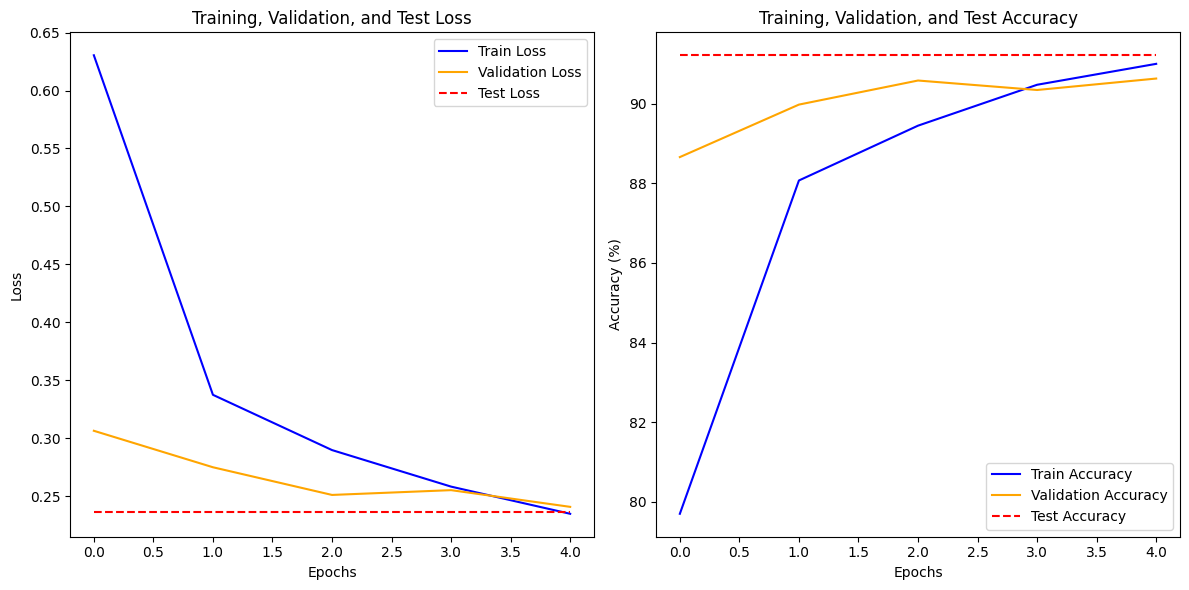

In [8]:
def plot_metrics(train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy):
    epochs = len(train_loss)

    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_loss, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_loss, label='Validation Loss', color='orange')
    plt.plot(range(epochs), test_loss, label='Test Loss', color='red', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training, Validation, and Test Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracy, label='Train Accuracy', color='blue')
    plt.plot(range(epochs), val_accuracy, label='Validation Accuracy', color='orange')
    plt.plot(range(epochs), test_accuracy, label='Test Accuracy', color='red', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training, Validation, and Test Accuracy')
    plt.tight_layout()
    plt.show()

plot_metrics(train_loss_history, val_loss_history, test_loss_history, train_accuracy_history, val_accuracy_history, test_accuracy_history)

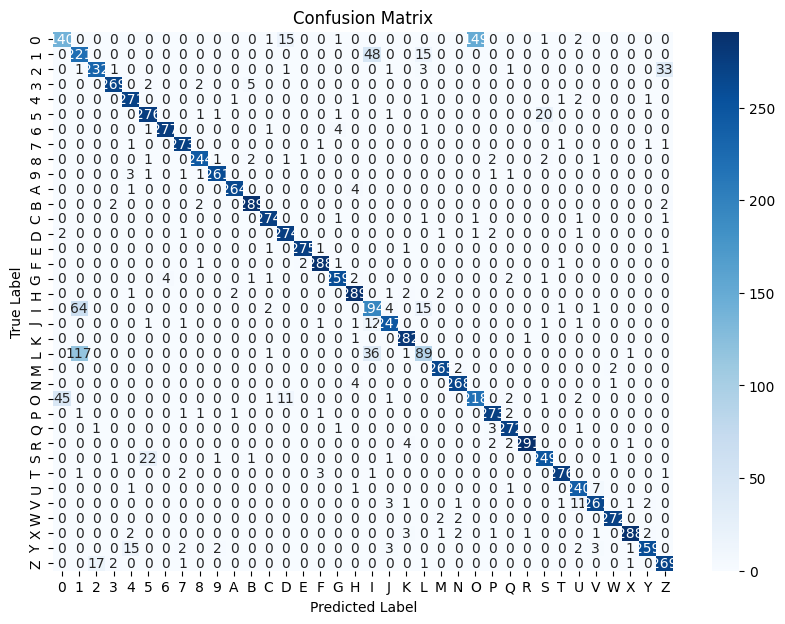

In [9]:
def plot_confusion_matrix(model, test_dataloader, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_dataloader, dataset.classes)


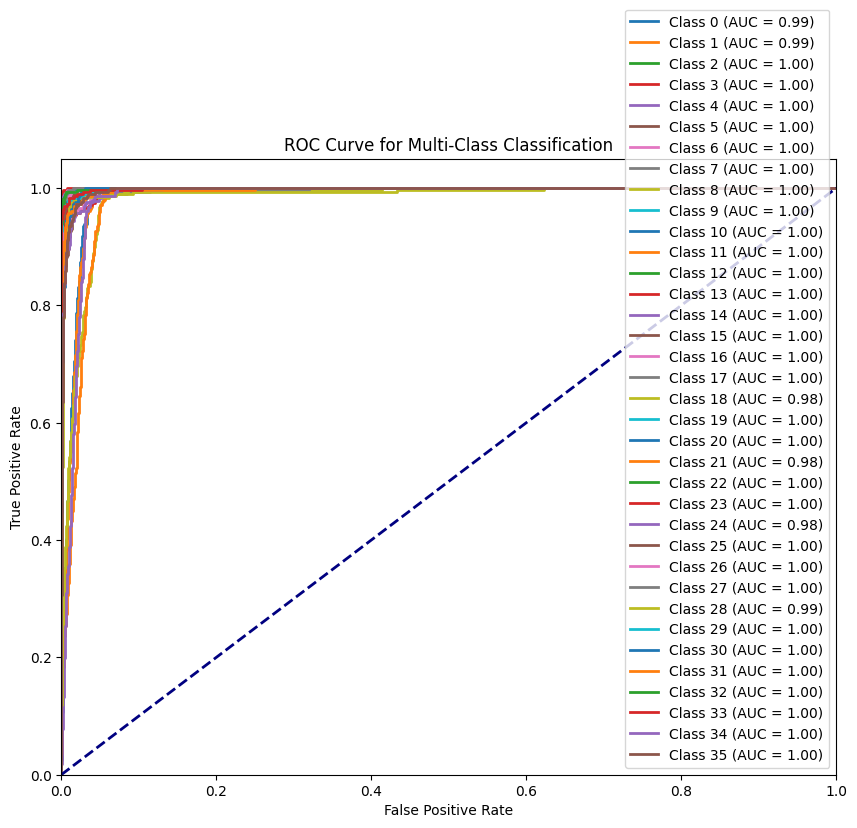

In [10]:
def plot_roc_curve(model, test_dataloader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    lb = LabelBinarizer()
    lb.fit(range(num_classes))
    all_labels_bin = lb.transform(all_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], [p[i] for p in all_preds])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(model, test_dataloader, num_classes=len(dataset.classes))


In [11]:
# Saving the best model
torch.save(model.state_dict(), "best_cnn_model.pt")
